In [ ]:
!python3 -m pip install sklearn
!python3 -m pip install numpy
!python3 -m pip install pandas
!python3 -m pip install matplotlib
!python3 -m pip install seaborn
!python3 -m pip install beautifulsoup4
!python3 -m pip install newspaper3k
!python3 -m pip install nltk

In [3]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
from newspaper import Article

from sklearn.metrics  import f1_score,accuracy_score
 
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# import tsv file
articles = pd.read_csv('newsArticlesWithLabels.tsv', sep='\t')
completed = pd.read_csv('articles_raw.csv')

start = 0

# for all the rows in the articles dataframe
for index, row in completed.iterrows():

    # if the row has text in the text column of the completed, continue
    if not pd.isnull(completed.loc[index, 'text']) or index < start:
        continue

    # get the url
    url = row['url']
    url.strip()
    # get the article
    article = Article(url)
    # download the article
    try:
        article.download()
        article.parse()
    except:
        continue
    # get the text
    text = article.text
    # remove the new lines
    text = text.replace('\n', ' ')
    # strip the text
    text = text.strip()
    # add the text to the dataframe
    completed.loc[index, 'text'] = text
    # save the dataframe to a csv file
    if index % 100 == 0:
        completed.to_csv('articles_raw.csv')
        print('saved rows up to', index)


In [12]:
# get the df
completed = pd.read_csv('articles_raw.csv')
# drop na
completed.dropna(inplace=True)
# drop urls with video.foxnews
completed = completed[~completed['url'].str.contains('video.foxnews')]
# save the df
completed.to_csv('articles_na_dropped.csv')

In [26]:
# load 
completed = pd.read_csv('articles_na_dropped.csv')

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

# get the articles
articles = completed['text'].values

In [35]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# remove english stopwords function
def remove_stopwords(text, language):
    text = text.lower()
    stop_words = set(stopwords.words(language))
    word_tokens = text.split()
    return " ".join([word for word in word_tokens if word not in stop_words])
    
# remove all non-letters keep spaces between words
articles = [re.sub("[^a-zA-Z ]", "", article) for article in articles]
articles = [remove_stopwords(article, 'english') for article in articles]

cv = CountVectorizer()

x = cv.fit_transform(articles)
x.toarray()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pbido\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from copy import copy

# parameters of classifier
k = 10

y_feat = 'democrat.vote'

y_true = completed.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# construction of kfold object
kfold = KFold(n_splits=3)

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    # estimate each penguin's species
    y_pred[test_idx] = knn_classifier.predict(x_test)

[Text(0, 0, 'Negative'),
 Text(1, 0, 'Neutral'),
 Text(2, 0, 'Positive'),
 Text(3, 0, 'SomewhatNegative'),
 Text(4, 0, 'SomewhatPositive')]

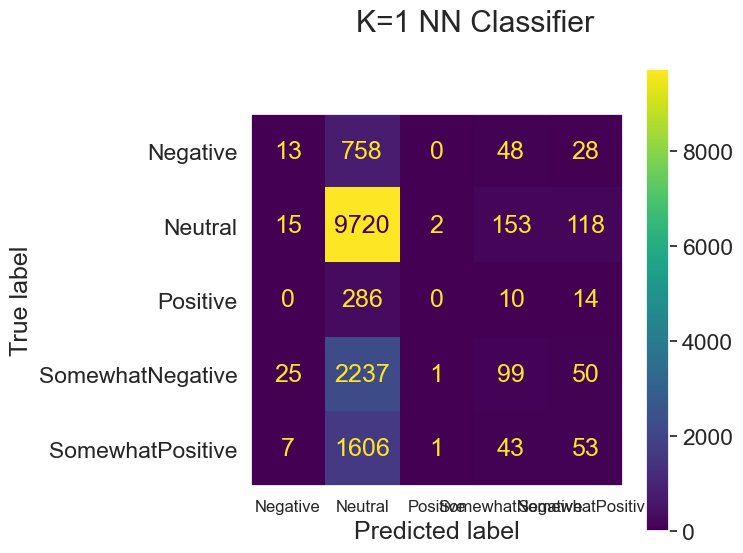

In [38]:
# build and plot confusion matrix
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))

sns.set(font_scale=1.5)
conf_mat_disp.plot()
plt.suptitle('K=1 NN Classifier')
plt.gcf().set_size_inches(6, 6)
plt.grid(False)

# change font size of predicted label
plt.gca().set_xticklabels(np.unique(y_true), fontsize=12)

In [ ]:
articles